### Import Libraries

In [3]:
import nltk
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , classification_report, plot_confusion_matrix

### Download and Load Stopwords

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sanga\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

### Load Stopwords - English

In [5]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stopwords.remove('not')

### Import Dataset and Select required Columns

In [7]:
dataset = pd.read_csv('labeled_data.csv')

In [8]:
dataset.head(5)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


### Drop Unwanted columns from dataset

In [9]:
data = dataset.iloc[:,-2:]

In [10]:
data.head(5)

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


### Checking Class Labels

In [11]:
data['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

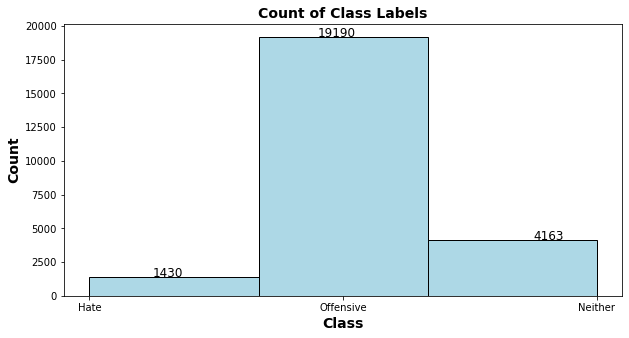

In [12]:
c0 = data['class'].value_counts()[0]
c1 = data['class'].value_counts()[1]
c2 = data['class'].value_counts()[2]
plt.figure(figsize=(10,5))
plt.hist(data['class'], bins = 3, color = 'lightblue', edgecolor = 'black')
plt.xlabel('Class', fontsize = 14, fontweight = 'bold')
plt.ylabel('Count', fontsize = 14, fontweight = 'bold')
plt.title('Count of Class Labels', fontsize = 14, fontweight = 'bold')
plt.xticks([0,1,2],['Hate', 'Offensive', 'Neither'])
plt.text(0.25,c0, str(c0), fontsize=12)
plt.text(0.9,c1, str(c1),fontsize=12)
plt.text(1.75,c2, str(c2),fontsize=12)
plt.show()

### Data Cleaning and Feature Selection

#### Create Stemming Object

In [13]:
ps = PorterStemmer()

#### Dictionary for Clitics Separation

In [14]:
contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "cause": "because", 
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had",
    "he'd've": "he would have",
    "he'll": "he shall",
    "he'll've": "he shall have",
    "he's": "he has",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how has",
    "i'd": "I had",
    "i'd've": "I would have",
    "i'll": "I shall",
    "i'll've": "I shall have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it shall",
    "it'll've": "it shall have",
    "it's": "it has",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she had",
    "she'd've": "she would have",
    "she'll": "she shall",
    "she'll've": "she shall have",
    "she's": "she has",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there has",
    "they'd": "they had",
    "they'd've": "they would have",
    "they'll": "they shall",
    "they'll've": "they shall have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what shall",
    "what'll've": "what shall have",
    "what're": "what are",
    "what's": "what has",
    "what've": "what have",
    "when's": "when has",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where has",
    "where've": "where have",
    "who'll": "who shall",
    "who'll've": "who shall have",
    "who's": "who has",
    "who've": "who have",
    "why's": "why has",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you shall",
    "you'll've": "you shall have",
    "you're": "you are",
    "you've": "you have",
    "that's": "that is",
    "ya": "you",
    "im": "I am"}

#### Creating Corpus of Words

In [15]:
corpus = []
for i in range(0, len(data)):
    #Convert to Lower case
    tweet = data['tweet'][i].lower()
    
    #Remove Usernames
    tweet = re.sub('@[\w]+','',tweet)
    
    #Remove URL
    tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
                    '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', tweet)
    
    #Split Clitics
    tweet = tweet.split()
    for j in range(0,len(tweet)):
      if tweet[j] in contractions.keys():
        tweet[j] = contractions[tweet[j]]
    tweet = ' '.join(tweet)

    #Remove Numbers and Special Characters
    tweet = re.sub('[^a-zA-Z]', ' ', tweet).strip()

    #Tokenization and Stemming words
    tweet = tweet.split()
    tweet = [ps.stem(word) for word in tweet if not word in set(stopwords)]
    tweet = ' '.join(tweet)
    corpus.append(tweet)

### Create Bag of Words using TfIdfVectorizer

In [16]:
tf = TfidfVectorizer(max_features=5000)
x = tf.fit_transform(corpus).toarray()

In [17]:
y = data.iloc[:, 0].values

### Split data into Train and Test Sets

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

### Applying Logistic Regression Model with 5-Fold Cross Validation

In [19]:
LR_classifier = LogisticRegression(random_state = 0, n_jobs = -1)

#### 5-Fold Cross Validation

In [20]:
CV_LR = cross_val_score(LR_classifier, x_train, y_train,cv = 5, n_jobs = -1)
CV_LR.mean()

0.9002530715698903

#### Fitting Training Data

In [21]:
LR_classifier.fit(x_train,y_train)

LogisticRegression(n_jobs=-1, random_state=0)

#### Confusion Matrix

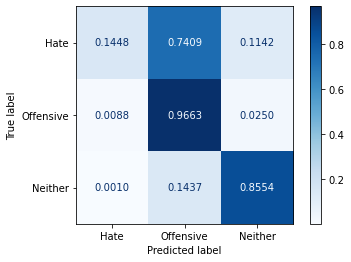

In [22]:
plot_confusion_matrix(LR_classifier,x_test, y_test, labels = [0,1,2], values_format = '.4f', cmap = plt.cm.Blues,
                      display_labels = ['Hate','Offensive','Neither'], normalize = 'true')
plt.show()

#### Classification Report

In [23]:
y_pred_LR = LR_classifier.predict(x_test)
print(classification_report(y_test, y_pred_LR, target_names=['Hate','Offensive','Neither']))

              precision    recall  f1-score   support

        Hate       0.55      0.14      0.23       359
   Offensive       0.92      0.97      0.94      4800
     Neither       0.85      0.86      0.85      1037

    accuracy                           0.90      6196
   macro avg       0.77      0.66      0.67      6196
weighted avg       0.88      0.90      0.89      6196



### Applying Random Forest Model with 5-fold cross validation

In [24]:
RF_classifier = RandomForestClassifier(n_estimators = 100, random_state = 0, n_jobs = -1)

#### 5-Fold Cross Validation

In [25]:
CV_RF = cross_val_score(RF_classifier, x_train, y_train, cv = 5, n_jobs = -1)
CV_RF.mean()

0.9068706174312432

#### Fitting Training Data

In [26]:
RF_classifier.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

#### Confusion Matrix

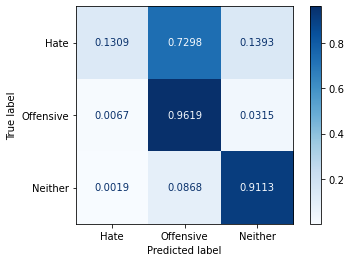

In [27]:
plot_confusion_matrix(RF_classifier,x_test, y_test, labels = [0,1,2], values_format = '.4f', cmap = plt.cm.Blues,
                      display_labels = ['Hate','Offensive','Neither'], normalize = 'true')
plt.show()

#### Classification Report

In [28]:
y_pred_RF = RF_classifier.predict(x_test)
print(classification_report(y_test, y_pred_RF, target_names=['Hate','Offensive','Neither']))

              precision    recall  f1-score   support

        Hate       0.58      0.13      0.21       359
   Offensive       0.93      0.96      0.95      4800
     Neither       0.82      0.91      0.87      1037

    accuracy                           0.91      6196
   macro avg       0.78      0.67      0.67      6196
weighted avg       0.89      0.91      0.89      6196



### Applying Linear SVM Model with 5-fold cross validation

In [29]:
LSVM_classifier = LinearSVC(random_state = 0)

#### 5-Fold Cross Validation

In [30]:
CV_LSVM = cross_val_score(LSVM_classifier, x_train, y_train, cv = 5, n_jobs = -1)
CV_LSVM.mean()

0.8940659369603307

#### Fit Training Data

In [31]:
LSVM_classifier.fit(x_train, y_train)

LinearSVC(random_state=0)

#### Confusion Matrix

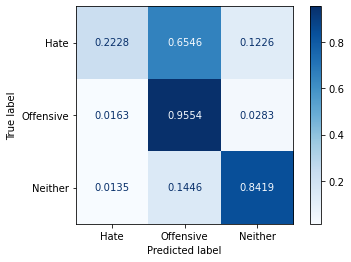

In [32]:
plot_confusion_matrix(LSVM_classifier,x_test, y_test, labels = [0,1,2], values_format = '.4f', cmap = plt.cm.Blues,
                      display_labels = ['Hate','Offensive','Neither'], normalize = 'true')
plt.show()

#### Classification Report

In [33]:
y_pred_LSVM = LSVM_classifier.predict(x_test)
print(classification_report(y_test, y_pred_LSVM, target_names=['Hate','Offensive','Neither']))

              precision    recall  f1-score   support

        Hate       0.47      0.22      0.30       359
   Offensive       0.92      0.96      0.94      4800
     Neither       0.83      0.84      0.84      1037

    accuracy                           0.89      6196
   macro avg       0.74      0.67      0.69      6196
weighted avg       0.88      0.89      0.88      6196



### Applying Kernel SVM with 5-fold Cross Validation

In [34]:
KSVM_classifier = SVC(kernel = 'rbf', random_state = 0)

#### 5-Fold Cross Validation

In [35]:
CV_KSVM = cross_val_score(KSVM_classifier, x_train, y_train, cv = 5, n_jobs = -1)
CV_KSVM.mean()

0.9036963471122533

#### Fit Training Data

In [36]:
KSVM_classifier.fit(x_train, y_train)

SVC(random_state=0)

#### Confusion Matrix(Test Set)

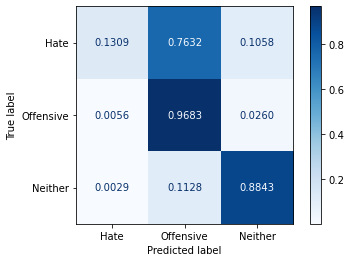

In [37]:
plot_confusion_matrix(KSVM_classifier,x_test, y_test, labels = [0,1,2], values_format = '.4f', cmap = plt.cm.Blues,
                      display_labels = ['Hate','Offensive','Neither'], normalize = 'true')
plt.show()

#### Classification Report(Test Set)

In [38]:
y_pred_KSVM = KSVM_classifier.predict(x_test)
print(classification_report(y_test, y_pred_KSVM, target_names=['Hate','Offensive','Neither']))

              precision    recall  f1-score   support

        Hate       0.61      0.13      0.22       359
   Offensive       0.92      0.97      0.94      4800
     Neither       0.85      0.88      0.87      1037

    accuracy                           0.91      6196
   macro avg       0.79      0.66      0.68      6196
weighted avg       0.89      0.91      0.89      6196

